In [1]:
# !pip install -U scikit-learn
# !pip install pandas -U
# !pip install numpy -U
# !pip install imbalanced-learn -U

# Прогнозирование оттока клиентов оператора связи

Предоставлены персональные данные о некоторых клиентах, информация об их тарифах и договорах.

**Цель**: Обучить модель, способную предсказывать клиентов, которые могут уйти.

**Целевой признак**: IsWithdraw - Уйдет клиент или нет (создан на основе данных).

Метрика ROC AUC должна быть как минимум выше 0.85, в идеале - выше 0.88

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

## Загрузка и подготовка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)

In [4]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

### Первичный осмотр данных

- Посмотрим на данные, их количество, пропуски и их типы

In [5]:
contract.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85


In [6]:
personal.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No


In [7]:
internet.head(1)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No


In [8]:
phone.head(1)

,customerID,MultipleLines
0,5575-GNVDE,No


In [9]:
for i in [(contract, 'contract'), (personal, 'personal'), (internet, 'internet'), (phone, 'phone')]:
    print(i[1])
    i[0].info()
    print('')

contract
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

personal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-n

- Часть клиентов не пользуются интернетом и несколькими линиями
- Ни в одной таблице нет пропусков
- Нужно изменить тип данных для столбца общих списаний в таблице о контракте

### Объединение данных и обработка пропущенных значений

- Объединим данные в одну таблицу

In [10]:
count=0
for i in [contract, personal, internet, phone]:
    print(i.shape)
    count+=i.shape[1]-1
    
count+=1
count

(7043, 8)
(7043, 5)
(5517, 8)
(6361, 2)


20

In [11]:
conper = contract.merge(personal, how='outer', on='customerID')                     
conperint = conper.merge(internet, how='outer', on='customerID')                   
telecom = conperint.merge(phone, how='outer', on='customerID')
                         
telecom.shape

(7043, 20)

In [12]:
telecom.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

- Пропуски появились для тех пользователей, который не используют интернет и многоканальные линии для телефонных звонков
- Образовавшиеся пропущенные значения заполним значением No

In [13]:
telecom.fillna('No', inplace=True)

In [14]:
telecom.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

- Проверим дубликаты

In [15]:
telecom.duplicated().sum()

0

In [16]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


- Проверим также уникальные значения для всех столбцов, кроме айди и дат

In [17]:
for c in telecom.columns:
    if telecom[c].dtype=='object' and c!='customerID' and c!='BeginDate':
        print(c)
        print(telecom[c].value_counts())
        print('')

EndDate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Type
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

PaperlessBilling
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

TotalCharges
          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

gender
Male      3555
Female    3488
Name: gender, dtype: int64

Partner
No     3641
Yes    3402
Name: Partner, dtype: int64

Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64

InternetService
Fiber optic    3096
DSL            2421
No    

- В толбце общих списаний есть значений в виде пробела, нужно разобраться в чем здесь дело
- Как будет показано дальше, самый первый подключившийся клиент из данных оформил контракт в 2013 году, но даты расторжения контракта представлены лишь 4 значениями: октябрь, ноябрь и декабрь 2019 года и январь 2020

### Преобразование типов данных и расчет новых признаков

- Посчитаем количество дней, которые клиент пользовался услугами мобильного оператора - Lifetime
- Не у всех клиентов есть дата окончания пользования услугами, для них мы заполним пропуски датой 1 февраля 2020 года, т.к. на эту дату предоставлены данные

In [18]:
telecom['EndDate_temp'] = telecom['EndDate']
telecom['EndDate_temp'] = telecom['EndDate_temp'].apply(lambda x: '2020-02-01 00:00:00' if x=='No' else x)

telecom['BeginDate_temp'] = telecom['BeginDate']

In [19]:
telecom['BeginDateDT'] = pd.to_datetime(telecom['BeginDate_temp'], format='%Y-%m-%d')
telecom['EndDateDT'] = pd.to_datetime(telecom['EndDate_temp'], format='%Y-%m-%d')

In [20]:
telecom['BeginDateDT'].min()

Timestamp('2013-10-01 00:00:00')

In [21]:
telecom['Lifetime'] = (telecom['EndDateDT']-telecom['BeginDateDT']).dt.days

- Пробелы в общих списаниях указаны для пользователей, чьи даты начала пользованием услуг оператора указаны как 1 февраля 2020 года - дата, на момент которой имеются данные
- Таких пользователей немного, поэтому просто уберем их

In [22]:
len(telecom.loc[telecom['TotalCharges'] == ' ', 'TotalCharges'].index)

11

In [23]:
telecom.shape[0]

7043

In [24]:
telecom.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042],
           dtype='int64', length=7043)

In [25]:
telecom.drop(telecom.loc[telecom['TotalCharges'] == ' ', 'TotalCharges'].index, inplace=True)

In [26]:
telecom.shape[0]

7032

In [27]:
telecom.reset_index(inplace=True, drop=True)

In [28]:
telecom.index

RangeIndex(start=0, stop=7032, step=1)

In [29]:
telecom['TotalCharges'] = telecom['TotalCharges'].astype('float')

In [30]:
# telecom['ResidualCharges'] = telecom['TotalCharges'] - telecom['MonthlyCharges'] 

In [31]:
telecom.shape[1]

25

In [32]:
# telecom.drop(columns=['TotalCharges'], inplace=True)

In [33]:
telecom.shape[1]

25

- Создаем целевой признак, присваивая 1 тем пользователям, у которых указана дата в столбце EndDate, иначе 0

In [34]:
telecom['IsWithdraw'] = telecom['EndDate'].apply(lambda x: 1 if x!='No' else 0)

- Чтобы избежать утечки данных, удалим все столбцы с датами, участвовавшие в расчете признака Lifetime

In [35]:
telecom.drop(columns=['BeginDateDT', 'EndDateDT', 'EndDate', 'BeginDate', 'BeginDate_temp', 'EndDate_temp'], inplace=True)

In [36]:
telecom.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Lifetime,IsWithdraw
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,1
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,1


In [37]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   gender            7032 non-null   object 
 7   SeniorCitizen     7032 non-null   int64  
 8   Partner           7032 non-null   object 
 9   Dependents        7032 non-null   object 
 10  InternetService   7032 non-null   object 
 11  OnlineSecurity    7032 non-null   object 
 12  OnlineBackup      7032 non-null   object 
 13  DeviceProtection  7032 non-null   object 
 14  TechSupport       7032 non-null   object 
 15  StreamingTV       7032 non-null   object 
 16  StreamingMovies   7032 non-null   object 


## Исследовательский анализ данных

### Анализ количественных признаков

- Посмотрим на статистическую сводку по количественным переменным

In [38]:
telecom.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,Lifetime,IsWithdraw
count,7032.00,7032.00,7032.00,7032.00,7032.00
mean,64.80,2283.30,0.16,987.54,0.27
std,30.09,2266.77,0.37,747.15,0.44
min,18.25,18.80,0.00,30.00,0.00
25%,35.59,401.45,0.00,275.00,0.00
50%,70.35,1397.47,0.00,883.00,0.00
75%,89.86,3794.74,0.00,1676.00,1.00
max,118.75,8684.80,1.00,2191.00,1.00


- Оценим рампределение классов целевого признака

In [39]:
telecom['IsWithdraw'].value_counts()

0    5163
1    1869
Name: IsWithdraw, dtype: int64

- У нас виден явный дисбаланс класс, который нужно учесть перед обучением моделей

- Рассмотрим отдельно распределения признаков ежемесячные списания, общие списания и время жизни клиента для разных классов целевого признака

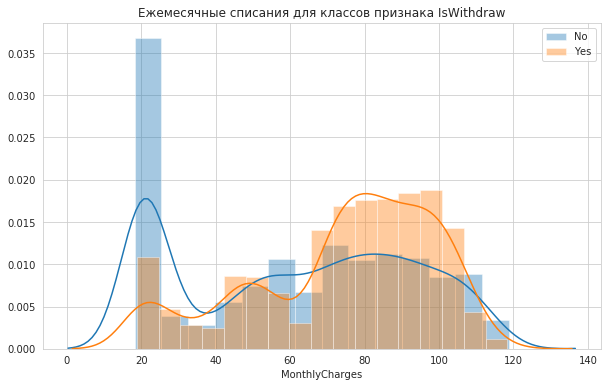

In [40]:
plt.figure(figsize=(10, 6))
sns.distplot(telecom[telecom['IsWithdraw']==0]['MonthlyCharges'])
sns.distplot(telecom[telecom['IsWithdraw']==1]['MonthlyCharges'])
plt.legend(['No', 'Yes'])
plt.title('Ежемесячные списания для классов признака IsWithdraw')
plt.show()

- Видно, что контракт расторгли клиенты в среднем с более высокими ежемесячными списаниями

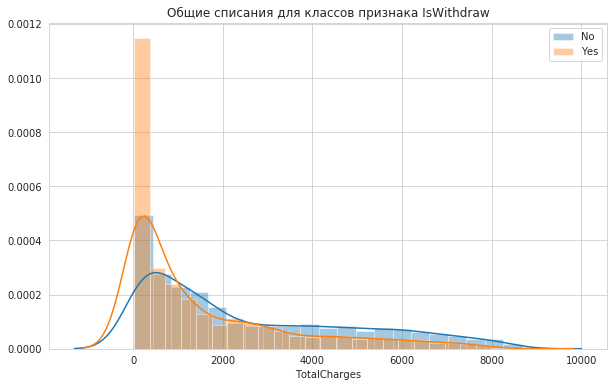

In [41]:
plt.figure(figsize=(10, 6))
sns.distplot(telecom[telecom['IsWithdraw']==0]['TotalCharges'])
sns.distplot(telecom[telecom['IsWithdraw']==1]['TotalCharges'])
plt.legend(['No', 'Yes'])
plt.title('Общие списания для классов признака IsWithdraw')
plt.show()

- Здесь же заметно, что многие ушедшие клиенты имели близкие к нулю общие списания, что вероятно указывает на тех клиентов, что ушел сразу же после подключения услуг, посмотрим теперь данные по времени жизни клиента

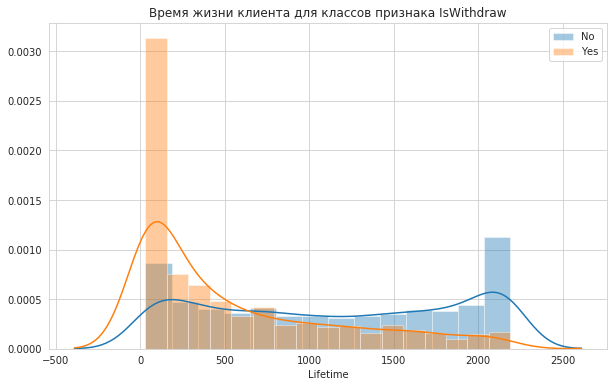

In [42]:
plt.figure(figsize=(10, 6))
sns.distplot(telecom[telecom['IsWithdraw']==0]['Lifetime'])
sns.distplot(telecom[telecom['IsWithdraw']==1]['Lifetime'])
plt.legend(['No', 'Yes'])
plt.title('Время жизни клиента для классов признака IsWithdraw')
plt.show()

- Здесь подтверждается выдвинутая ранее гипотеза: большая часть ушедших клиентов являются теми, кто ушел сразу же после подключения услуг

- Теперь посмотрим на возможные линейные зависимости между количественными переменными

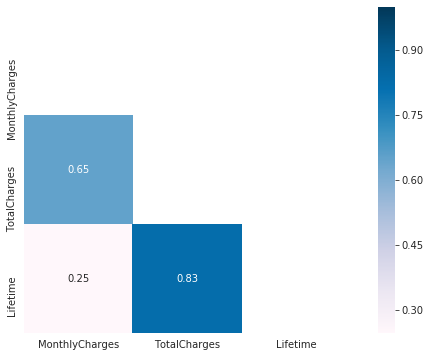

In [43]:
mask = np.triu(telecom[['MonthlyCharges', 'TotalCharges', 'Lifetime']].corr())
fig = plt.subplots(figsize=(10, 6))
sns.heatmap(telecom[['MonthlyCharges', 'TotalCharges', 'Lifetime']].corr(), 
            annot=True, 
            cmap= 'PuBu', 
            square=True, 
            mask=mask,
           )
plt.show()

- Наблюдается хорошая линейная зависимость между признакими TotalCharges и Lifetime, посмотрим для начала на скаттерплоты, а затем уберем признак TotalCharges

- Посмотрим теперь зависимости времени жизни клиента от месячных и общих списаний

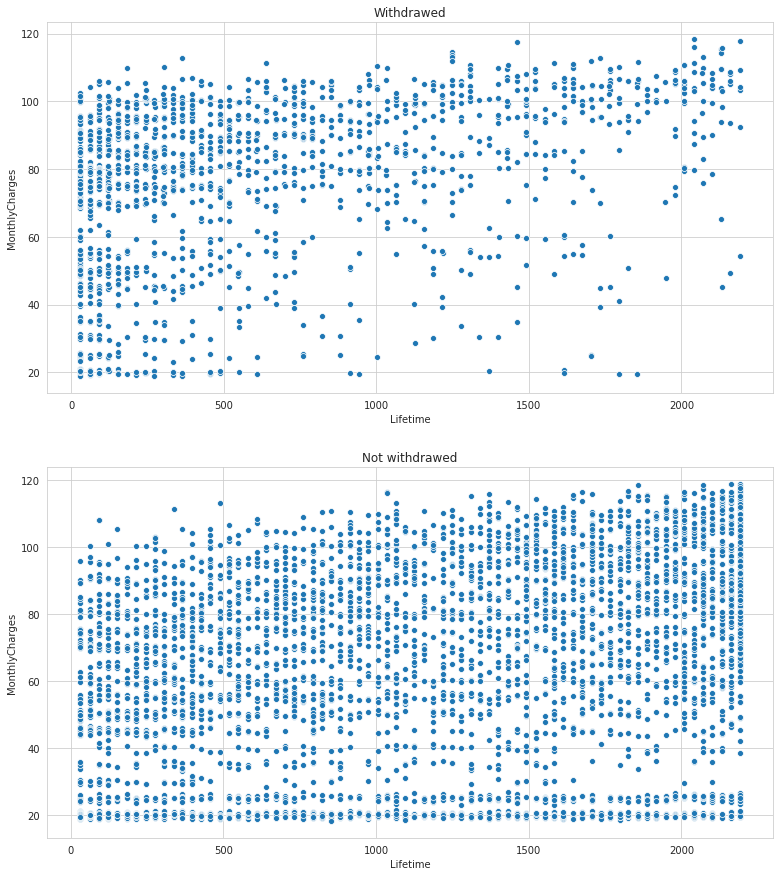

In [44]:
fig, axs = plt.subplots(2, 
                        1, 
                        figsize=(13,15), 
                        #sharex=True, 
                        #sharey=True
                       )

sns.scatterplot(x='Lifetime', y='MonthlyCharges', data=telecom[telecom['IsWithdraw']==1], ax=axs[0])
axs[0].set_title('Withdrawed')
sns.scatterplot(x='Lifetime', y='MonthlyCharges', data=telecom[telecom['IsWithdraw']==0], ax=axs[1])
axs[1].set_title('Not withdrawed')

plt.show()

- Видно, что ушедшие клиенты как правило имели самые большие для данного времени жизни месячные расходы, т.е. клиенты вероятно уходили по причине высоких месячных трат на услуги

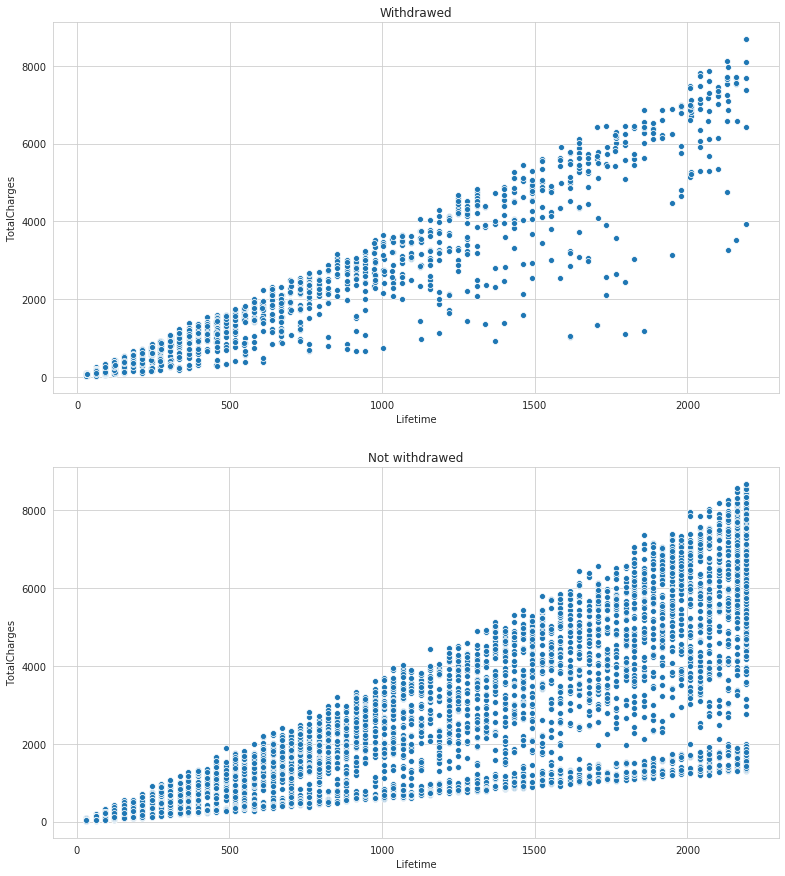

In [45]:
fig, axs = plt.subplots(2, 
                        1, 
                        figsize=(13,15), 
                        #sharex=True, 
                        #sharey=True
                       )

sns.scatterplot(x='Lifetime', y='TotalCharges', data=telecom[telecom['IsWithdraw']==1], ax=axs[0])
axs[0].set_title('Withdrawed')
sns.scatterplot(x='Lifetime', y='TotalCharges', data=telecom[telecom['IsWithdraw']==0], ax=axs[1])
axs[1].set_title('Not withdrawed')

plt.show()

- Общие списания также подтверждают предыдущие выводы: ушедшие клиенты имели максимальные общие траты для каждого значения времени жизни клиента

- Удалим один из двух коррелирующих признака - TotalCharges

In [46]:
telecom.shape

(7032, 20)

In [47]:
telecom.drop(columns=['TotalCharges'], inplace=True)

In [48]:
telecom.shape

(7032, 19)

In [49]:
telecom.head(1)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Lifetime,IsWithdraw
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0


### Анализ категориальных признаков

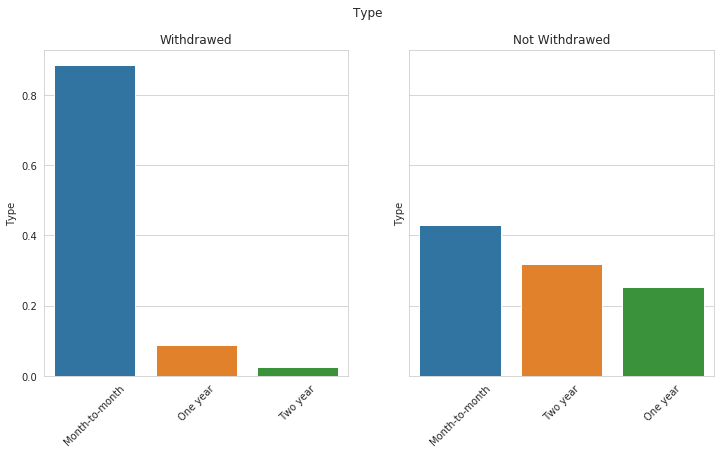

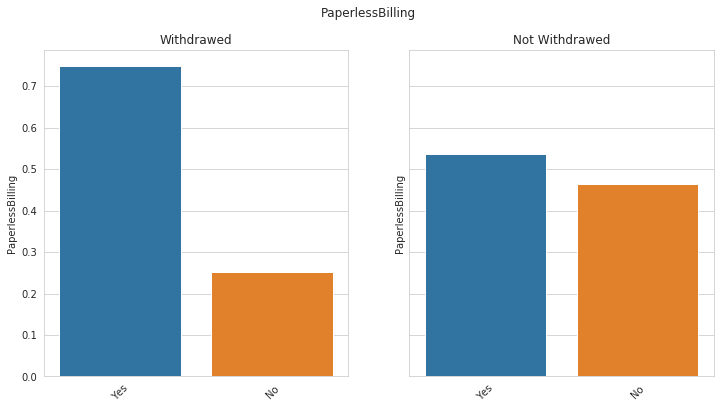

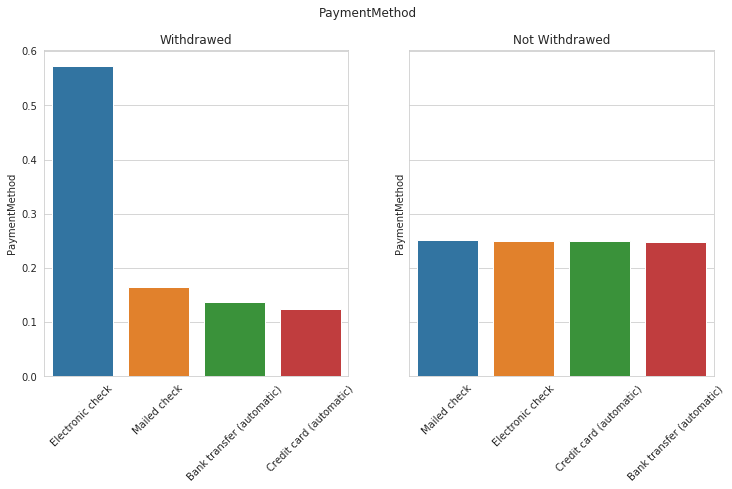

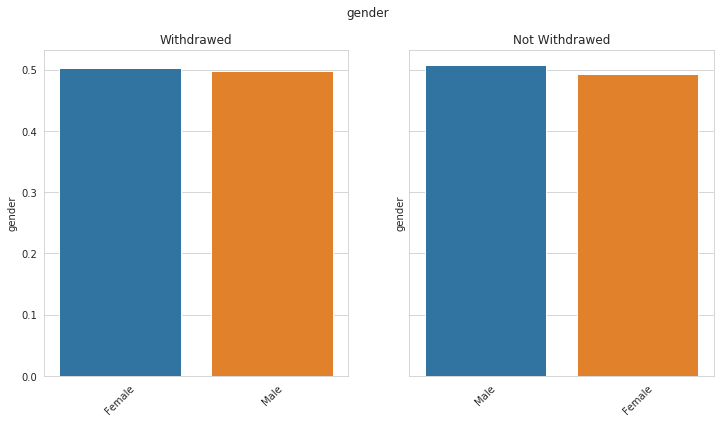

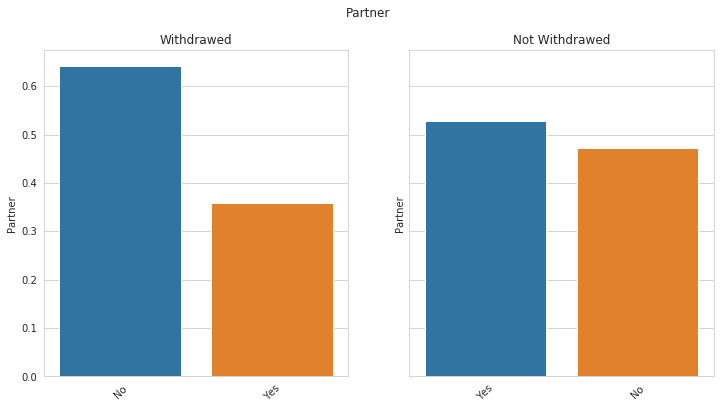

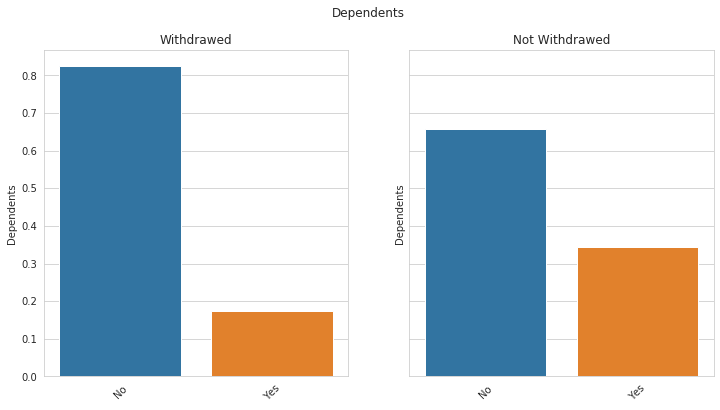

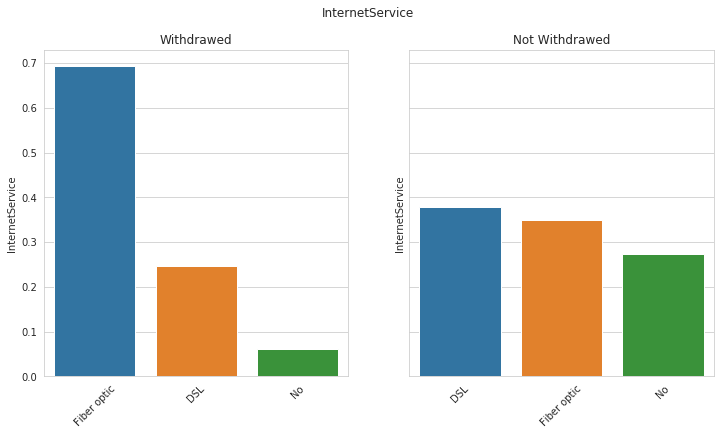

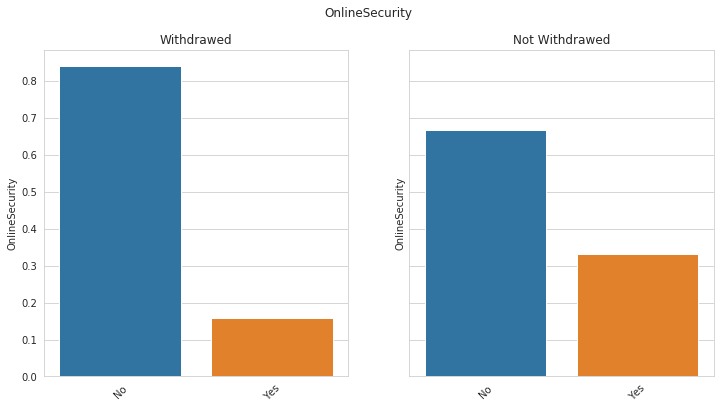

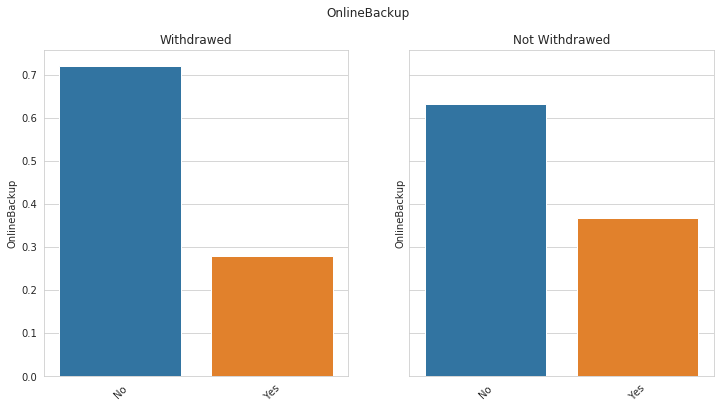

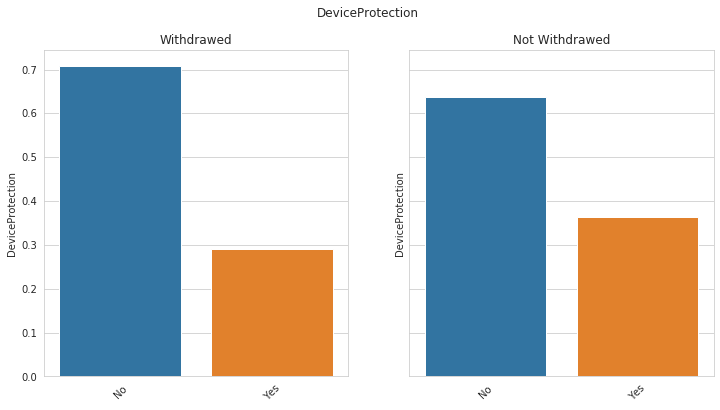

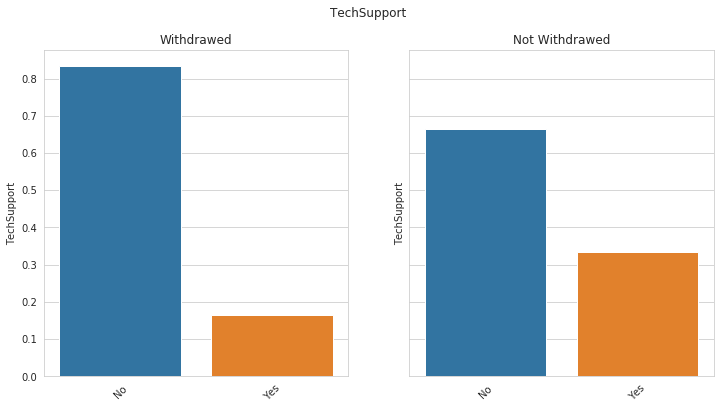

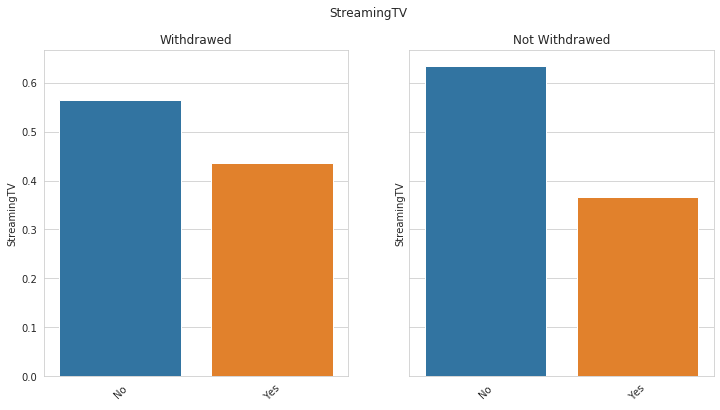

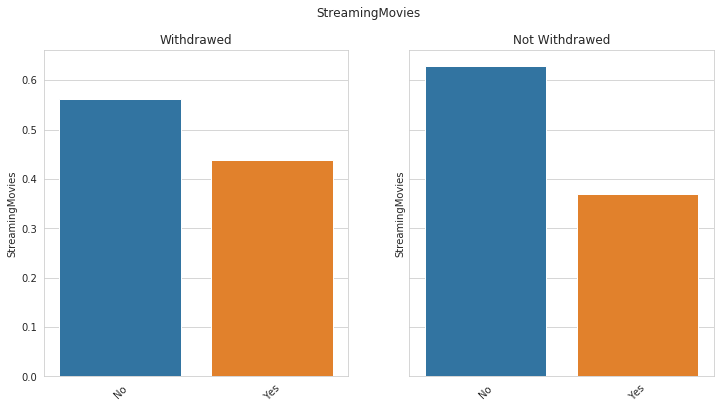

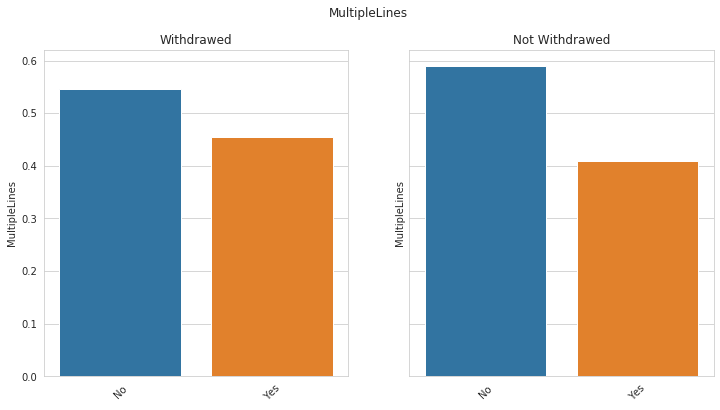

In [50]:
for c in telecom.columns:
    if telecom[c].dtype=='object' and c!='customerID':
        fig, axs = plt.subplots(1, 
                        2, 
                        figsize=(12,6),
                        sharey=True
                       )
        sns.barplot(telecom.loc[telecom['IsWithdraw']==1, c].value_counts(normalize=True).index, 
                    telecom.loc[telecom['IsWithdraw']==1, c].value_counts(normalize=True),
                    #palette='RdBu',
                    ax=axs[0]
                   )
        axs[0].set_title('Withdrawed')
        axs[0].tick_params(axis='x', labelrotation=45)
        
        sns.barplot(telecom.loc[telecom['IsWithdraw']==0, c].value_counts(normalize=True).index, 
                    telecom.loc[telecom['IsWithdraw']==0, c].value_counts(normalize=True),
                    #palette='RdBu',
                    ax=axs[1]
                   )
        axs[1].set_title('Not Withdrawed')
        axs[1].tick_params(axis='x', labelrotation=45)
        
        fig.suptitle(c)
        plt.show()

- Совершенно точно на решение об уходе клиента не влияет его пол, поэтому признак gender можно убрать
- Небольшие различия (меньше 0.1) наблюдаются для признаков, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies и MultipleLines. Попробуем убрать также и эти признаки
- Кроме того, мы видим, что в признаке PaymentMethod по сути сильно различается только Electronic check, поэтому далее после кодирования категориальных признаков удалим все столбцы, кроме Electronic check

In [52]:
cat_feats_to_drop = ['gender', 
                     'OnlineBackup', 
                     'DeviceProtection', 
                     'StreamingTV', 
                     'StreamingMovies', 
                     'MultipleLines'
                    ]

In [53]:
len(cat_feats_to_drop)

6

In [54]:
telecom.shape

(7032, 19)

In [55]:
telecom.drop(columns=cat_feats_to_drop, inplace=True)

In [56]:
telecom.shape

(7032, 13)

**Выводы**

- Выделются две возможные основные причины ухода клиентов:
    1. Высокие стоимости услуг. Возможно большая часть клиентов уходили сразу же после подключения из-за высокой стоимости услуг, вероятно не до конца изучив условия выбранных тарифов, либо же клиенты со временем понимали, что их использование тарифа им невыгодно и дорого
    2. Недостаточно внимательное или плохо организованное обращение и ведение новых подключившихся клиентом. Большая часть новых клиентов сразу же уходили из-за плохого сервиса и некачественного оказания услуг

## Обучение моделей

### Подготовка категориальных признаков и разделение данных

- Целевой признак IsWithdraw показывает, ушел клиент или нет. Наличие двух классов у целевого признака говорит нам о задачи бинарной классификации. Обучим следующие модели:
    - LogisticRegression
    - RandomForestClassifier
    - LGBMClassifier
- Качество моделей будем оценивать по Accuracy и ROC AUC

In [57]:
seed = 24
cv_k = 5
scoring = 'roc_auc'
scoring_alt = 'accuracy'

In [58]:
telecom_dropped = telecom.drop(columns=['customerID', 'IsWithdraw'])
X = pd.get_dummies(telecom_dropped, drop_first=True)

y = telecom.loc[:, 'IsWithdraw']

- Удалим также столбцы PaymentMethod_Credit card (automatic) и PaymentMethod_Mailed check из датафрейма признаков

In [59]:
X.drop(columns=['PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check'], inplace=True)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=seed, 
                                                    stratify=y
                                                   )

In [61]:
telecom.head(1)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,TechSupport,Lifetime,IsWithdraw
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,0,Yes,No,DSL,No,No,31,0


In [62]:
X.head(1)

,MonthlyCharges,SeniorCitizen,Lifetime,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Electronic check,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,TechSupport_Yes
0,29.85,0,31,0,0,1,1,1,0,0,0,0,0


In [63]:
display(X.columns)

Index(['MonthlyCharges', 'SeniorCitizen', 'Lifetime', 'Type_One year',
       'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Electronic check', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes', 'TechSupport_Yes'],
      dtype='object')

### Учет дисбаланса классов целевого признака

- Для учета дисбаланса классов целевого признака воспользуемся техникой оверсемплинга и функцией SMOTE
- Объединим стандартизацию количественных признаков, оверсемплинг, обучение и подбор гиперпараметров с помощью GridSearch и оценку качества модели по ROC AUC и Accuracy на тестовой выборке в одну функцию, которая будет возвращать лучшие гиперпараметры, значения метрик, предсказанные значения и сами модели

In [64]:
def imb_model_score_pipeline(X_train, 
                             y_train, 
                             X_test, 
                             y_test, 
                             model, 
                             seed, 
                             gs_params, 
                             cv_k, 
                             oversampling=True, 
                             scale=True, 
                             randomized_cv=False
                            ):
    """
    
    """
    
    if scale:
        if oversampling==False:
            imb_pipeline = make_pipeline(StandardScaler(), 
                                         model
                                        )
        else:
            imb_pipeline = make_pipeline(StandardScaler(),
                                         SMOTE(random_state=seed), 
                                         model
                                        )
    else:
        if oversampling==False:
            imb_pipeline = model
        else:
            imb_pipeline = make_pipeline(SMOTE(random_state=seed), 
                                         model
                                        )
    
    if randomized_cv:
        grid_imb = RandomizedSearchCV(imb_pipeline, 
                                      param_grid=gs_params, 
                                      cv=cv_k, 
                                      scoring='roc_auc', 
                                      return_train_score=True,
                                      #refit=scoring
                                     )
    else:
        grid_imb = GridSearchCV(imb_pipeline, 
                                param_grid=gs_params, 
                                cv=cv_k, 
                                scoring='roc_auc', 
                                return_train_score=True,
                                #refit=scoring
                               )
    
    grid_imb.fit(X_train, y_train)
    
    best_model = grid_imb.best_estimator_
    best_params = grid_imb.best_params_
    
    y_pred_probs = best_model.predict_proba(X_test)
    y_pred_probs_ones = best_model.predict_proba(X_test)[:, 1]
    
    y_pred = best_model.predict(X_test)
    
    test_roc_auc = roc_auc_score(y_test, y_pred_probs_ones).round(4)
    test_acc = accuracy_score(y_test, y_pred).round(4)
    
    val_roc_auc = np.nanmean(grid_imb.cv_results_['mean_test_score']).round(4)
    #val_roc_auc = np.nanmean(grid_imb.cv_results_['mean_test_roc_auc']).round(4)
    #val_acc = np.nanmean(grid_imb.cv_results_['mean_test_accuracy']).round(4)
    
    train_roc_auc = np.nanmean(grid_imb.cv_results_['mean_train_score']).round(4)
    #train_roc_auc = np.nanmean(grid_imb.cv_results_['mean_train_roc_auc']).round(4)
    #train_acc = np.nanmean(grid_imb.cv_results_['mean_train_accuracy']).round(4)
    
    return best_params, test_roc_auc, test_acc, val_roc_auc, train_roc_auc, y_pred, y_pred_probs, best_model

### LogisticRegression

In [65]:
hps_logreg = {'logisticregression__C': np.logspace(-5, 10, 20),
              'logisticregression__penalty': ['l1', 'l2']
              }

**Без учета дисбаланса классов**

In [66]:
%%time

nw_logreg_best_params, \
nw_logreg_test_roc_auc, \
nw_logreg_test_acc, \
nw_logreg_val_roc_auc, \
nw_logreg_train_roc_auc, \
_, \
_, \
nw_logreg = imb_model_score_pipeline(X_train, 
                                     y_train, 
                                     X_test, 
                                     y_test, 
                                     LogisticRegression(random_state=seed), 
                                     seed, 
                                     hps_logreg, 
                                     cv_k,
                                     oversampling=False
                                    )

CPU times: user 15.3 s, sys: 18.4 s, total: 33.8 s
Wall time: 33.7 s


In [67]:
print(f'Best parameters: {nw_logreg_best_params}')
print('')
print(f'Train ROC AUC: {nw_logreg_train_roc_auc}')
print(f'Validation ROC AUC: {nw_logreg_val_roc_auc}')
print(f'Test ROC AUC: {nw_logreg_test_roc_auc}')
print('')
#print(f'Train Accuracy: {nw_logreg_train_acc}')
#print(f'Validation Accuracy: {nw_logreg_val_acc}')
print(f'Test Accuracy: {nw_logreg_test_acc}')

Best parameters: {'logisticregression__C': 0.01438449888287663, 'logisticregression__penalty': 'l2'}

Train ROC AUC: 0.8442
Validation ROC AUC: 0.8421
Test ROC AUC: 0.832

Test Accuracy: 0.7844


*Значения метрик без удаления TotalCharges и лишних категориальных признаков:*

- Train ROC AUC: 0.85
- Validation ROC AUC: 0.8465
- Test ROC AUC: 0.8347

- Test Accuracy: 0.7861

**Присвоение весов классам**

In [68]:
%%time

w_logreg_best_params, \
w_logreg_test_roc_auc, \
w_logreg_test_acc, \
w_logreg_val_roc_auc, \
w_logreg_train_roc_auc, \
_, \
_, \
w_logreg = imb_model_score_pipeline(X_train, 
                                    y_train, 
                                    X_test, 
                                    y_test, 
                                    LogisticRegression(random_state=seed, class_weight='balanced'), 
                                    seed, 
                                    hps_logreg, 
                                    cv_k,
                                    oversampling=False
                                   )

CPU times: user 16.6 s, sys: 21.1 s, total: 37.8 s
Wall time: 38.1 s


In [69]:
print(f'Best parameters: {w_logreg_best_params}')
print('')
print(f'Train ROC AUC: {w_logreg_train_roc_auc}')
print(f'Validation ROC AUC: {w_logreg_val_roc_auc}')
print(f'Test ROC AUC: {w_logreg_test_roc_auc}')
print('')
#print(f'Train Accuracy: {w_logreg_train_acc}')
#print(f'Validation Accuracy: {w_logreg_val_acc}')
print(f'Test Accuracy: {w_logreg_test_acc}')

Best parameters: {'logisticregression__C': 0.01438449888287663, 'logisticregression__penalty': 'l2'}

Train ROC AUC: 0.8441
Validation ROC AUC: 0.8422
Test ROC AUC: 0.8323

Test Accuracy: 0.7389


*Значения метрик без удаления TotalCharges и лишних категориальных признаков:*

- Train ROC AUC: 0.8499
- Validation ROC AUC: 0.8465
- Test ROC AUC: 0.8345
- Test Accuracy: 0.7349

**С учетом дисбаланса классов**

In [70]:
%%time

logreg_best_params, \
logreg_test_roc_auc, \
logreg_test_acc, \
logreg_val_roc_auc, \
logreg_train_roc_auc, \
_, \
_, \
logreg = imb_model_score_pipeline(X_train, 
                                  y_train, 
                                  X_test, 
                                  y_test, 
                                  LogisticRegression(random_state=seed), 
                                  seed, 
                                  hps_logreg, 
                                  cv_k
                                 )

CPU times: user 21.5 s, sys: 21.4 s, total: 42.9 s
Wall time: 42.9 s


In [71]:
print(f'Best parameters: {logreg_best_params}')
print('')
print(f'Train ROC AUC: {logreg_train_roc_auc}')
print(f'Validation ROC AUC: {logreg_val_roc_auc}')
print(f'Test ROC AUC: {logreg_test_roc_auc}')
print('')
#print(f'Train Accuracy: {logreg_train_acc}')
#print(f'Validation Accuracy: {logreg_val_acc}')
print(f'Test Accuracy: {logreg_test_acc}')

Best parameters: {'logisticregression__C': 0.01438449888287663, 'logisticregression__penalty': 'l2'}

Train ROC AUC: 0.8442
Validation ROC AUC: 0.8424
Test ROC AUC: 0.8324

Test Accuracy: 0.7412


*Значения метрик без удаления TotalCharges и лишних категориальных признаков:*

- Train ROC AUC: 0.8501
- Validation ROC AUC: 0.8466
- Test ROC AUC: 0.8344
- Test Accuracy: 0.7469

### RandomForestClassifier

In [72]:
hps_rf = {'max_depth': np.arange(6, 9),
          'n_estimators': [100, 500],
          'min_samples_leaf': [1, 2, 3, 4]
         }

**Без учета дисбаланса классов**

In [73]:
%%time

nw_rf_best_params, \
nw_rf_test_roc_auc, \
nw_rf_test_acc, \
nw_rf_val_roc_auc, \
nw_rf_train_roc_auc, \
_, \
_, \
nw_rf = imb_model_score_pipeline(X_train, 
                                 y_train, 
                                 X_test, 
                                 y_test, 
                                 RandomForestClassifier(random_state=seed), 
                                 seed, 
                                 hps_rf, 
                                 cv_k,
                                 oversampling=False,
                                 scale=False
                                )

CPU times: user 1min 55s, sys: 0 ns, total: 1min 55s
Wall time: 1min 55s


In [74]:
print(f'Best parameters: {nw_rf_best_params}')
print('')
print(f'Train ROC AUC: {nw_rf_train_roc_auc}')
print(f'Validation ROC AUC: {nw_rf_val_roc_auc}')
print(f'Test ROC AUC: {nw_rf_test_roc_auc}')
print('')
#print(f'Train Accuracy: {nw_rf_train_acc}')
#print(f'Validation Accuracy: {nw_rf_val_acc}')
print(f'Test Accuracy: {nw_rf_test_acc}')

Best parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 500}

Train ROC AUC: 0.8952
Validation ROC AUC: 0.859
Test ROC AUC: 0.8548

Test Accuracy: 0.8083


*Значения метрик без удаления TotalCharges и лишних категориальных признаков:*

- Train ROC AUC: 0.8896
- Validation ROC AUC: 0.8575
- Test ROC AUC: 0.856
- Test Accuracy: 0.8106

**Присвоение весов классам**

In [75]:
%%time

w_rf_best_params, \
w_rf_test_roc_auc, \
w_rf_test_acc, \
w_rf_val_roc_auc, \
w_rf_train_roc_auc, \
_, \
_, \
w_rf = imb_model_score_pipeline(X_train, 
                                y_train, 
                                X_test, 
                                y_test, 
                                RandomForestClassifier(random_state=seed, class_weight='balanced'), 
                                seed, 
                                hps_rf, 
                                cv_k,
                                oversampling=False,
                                scale=False
                               )

CPU times: user 1min 55s, sys: 0 ns, total: 1min 55s
Wall time: 1min 56s


In [76]:
print(f'Best parameters: {w_rf_best_params}')
print('')
print(f'Train ROC AUC: {w_rf_train_roc_auc}')
print(f'Validation ROC AUC: {w_rf_val_roc_auc}')
print(f'Test ROC AUC: {w_rf_test_roc_auc}')
print('')
#print(f'Train Accuracy: {w_rf_train_acc}')
#print(f'Validation Accuracy: {w_rf_val_acc}')
print(f'Test Accuracy: {w_rf_test_acc}')

Best parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 100}

Train ROC AUC: 0.8936
Validation ROC AUC: 0.8576
Test ROC AUC: 0.8523

Test Accuracy: 0.7668


*Значения метрик без удаления TotalCharges и лишних категориальных признаков:*

- Train ROC AUC: 0.8882
- Validation ROC AUC: 0.8561
- Test ROC AUC: 0.8535
- Test Accuracy: 0.7725

**С учетом дисбаланса классов**

In [77]:
hps_rf_dc = {'randomforestclassifier__max_depth': np.arange(6, 9),
             'randomforestclassifier__n_estimators': [100, 500],
             'randomforestclassifier__min_samples_leaf': [1, 2, 3, 4]
             }

In [78]:
%%time

rf_best_params, \
rf_test_roc_auc, \
rf_test_acc, \
rf_val_roc_auc, \
rf_train_roc_auc, \
_, \
_, \
rf = imb_model_score_pipeline(X_train, 
                              y_train, 
                              X_test, 
                              y_test, 
                              RandomForestClassifier(random_state=seed), 
                              seed, 
                              hps_rf_dc, 
                              cv_k,
                              scale=False
                             )

CPU times: user 2min 19s, sys: 0 ns, total: 2min 19s
Wall time: 2min 20s


In [79]:
print(f'Best parameters: {rf_best_params}')
print('')
print(f'Train ROC AUC: {rf_train_roc_auc}')
print(f'Validation ROC AUC: {rf_val_roc_auc}')
print(f'Test ROC AUC: {rf_test_roc_auc}')
print('')
#print(f'Train Accuracy: {rf_train_acc}')
#print(f'Validation Accuracy: {rf_val_acc}')
print(f'Test Accuracy: {rf_test_acc}')

Best parameters: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 100}

Train ROC AUC: 0.8736
Validation ROC AUC: 0.8446
Test ROC AUC: 0.8333

Test Accuracy: 0.7622


*Значения метрик без удаления TotalCharges и лишних категориальных признаков:*

- Train ROC AUC: 0.8684
- Validation ROC AUC: 0.8438
- Test ROC AUC: 0.8379
- Test Accuracy: 0.7719

### LGBMClassifier

In [80]:
hps_gb_dc = {'lgbmclassifier__num_iterations': [1000],
             'lgbmclassifier__learning_rate': [0.1],
             'lgbmclassifier__max_depth': [5],
             'lgbmclassifier__reg_alpha': [2, 3],
             'lgbmclassifier__reg_lambda': [0.01, 0.1, 2]
             }

**Без учета дисбаланса классов**

In [81]:
%%time

nw_gb_best_params, \
nw_gb_test_roc_auc, \
nw_gb_test_acc, \
nw_gb_val_roc_auc, \
nw_gb_train_roc_auc, \
_, \
_, \
nw_gb = imb_model_score_pipeline(X_train, 
                                 y_train, 
                                 X_test, 
                                 y_test, 
                                 lgb.LGBMClassifier(random_state=seed), 
                                 seed, 
                                 hps_gb_dc, 
                                 cv_k,
                                 oversampling=False
                                )

CPU times: user 2min 18s, sys: 0 ns, total: 2min 18s
Wall time: 2min 20s


In [82]:
print(f'Best parameters: {nw_gb_best_params}')
print('')
print(f'Train ROC AUC: {nw_gb_train_roc_auc}')
print(f'Validation ROC AUC: {nw_gb_val_roc_auc}')
print(f'Test ROC AUC: {nw_gb_test_roc_auc}')
print('')
#print(f'Train Accuracy: {nw_gb_train_acc}')
#print(f'Validation Accuracy: {nw_gb_val_acc}')
print(f'Test Accuracy: {nw_gb_test_acc}')

Best parameters: {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 5, 'lgbmclassifier__num_iterations': 1000, 'lgbmclassifier__reg_alpha': 2, 'lgbmclassifier__reg_lambda': 0.01}

Train ROC AUC: 0.9645
Validation ROC AUC: 0.9095
Test ROC AUC: 0.9008

Test Accuracy: 0.8555


*Значения метрик после удаления TotalCharges:*

- Train ROC AUC: 0.9673
- Validation ROC AUC: 0.9074
- Test ROC AUC: 0.9048
- Test Accuracy: 0.8652

**Присвоение весов классам**

In [83]:
%%time

w_gb_best_params, \
w_gb_test_roc_auc, \
w_gb_test_acc, \
w_gb_val_roc_auc, \
w_gb_train_roc_auc, \
_, \
_, \
w_gb = imb_model_score_pipeline(X_train, 
                                y_train, 
                                X_test, 
                                y_test, 
                                lgb.LGBMClassifier(random_state=seed, is_unbalance=True), 
                                seed, 
                                hps_gb_dc, 
                                cv_k,
                                oversampling=False
                               )

CPU times: user 5min 17s, sys: 642 ms, total: 5min 17s
Wall time: 5min 21s


In [84]:
print(f'Best parameters: {w_gb_best_params}')
print('')
print(f'Train ROC AUC: {w_gb_train_roc_auc}')
print(f'Validation ROC AUC: {w_gb_val_roc_auc}')
print(f'Test ROC AUC: {w_gb_test_roc_auc}')
print('')
#print(f'Train Accuracy: {w_gb_train_acc}')
#print(f'Validation Accuracy: {w_gb_val_acc}')
print(f'Test Accuracy: {w_gb_test_acc}')

Best parameters: {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 5, 'lgbmclassifier__num_iterations': 1000, 'lgbmclassifier__reg_alpha': 2, 'lgbmclassifier__reg_lambda': 0.01}

Train ROC AUC: 0.9844
Validation ROC AUC: 0.9145
Test ROC AUC: 0.8985

Test Accuracy: 0.8464


*Значения метрик после удаления TotalCharges:*

- Train ROC AUC: 0.9866
- Validation ROC AUC: 0.9124
- Test ROC AUC: 0.8991
- Test Accuracy: 0.8424

**С учетом дисбаланса классов**

In [85]:
%%time

gb_best_params, \
gb_test_roc_auc, \
gb_test_acc, \
gb_val_roc_auc, \
gb_train_roc_auc, \
_, \
_, \
gb = imb_model_score_pipeline(X_train, 
                              y_train, 
                              X_test, 
                              y_test, 
                              lgb.LGBMClassifier(random_state=seed), 
                              seed, 
                              hps_gb_dc, 
                              cv_k
                             )

CPU times: user 2min 53s, sys: 1.77 s, total: 2min 55s
Wall time: 2min 58s


In [86]:
print(f'Best parameters: {gb_best_params}')
print('')
print(f'Train ROC AUC: {gb_train_roc_auc}')
print(f'Validation ROC AUC: {gb_val_roc_auc}')
print(f'Test ROC AUC: {gb_test_roc_auc}')
print('')
#print(f'Train Accuracy: {gb_train_acc}')
#print(f'Validation Accuracy: {gb_val_acc}')
print(f'Test Accuracy: {gb_test_acc}')

Best parameters: {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 5, 'lgbmclassifier__num_iterations': 1000, 'lgbmclassifier__reg_alpha': 2, 'lgbmclassifier__reg_lambda': 0.1}

Train ROC AUC: 0.9745
Validation ROC AUC: 0.9158
Test ROC AUC: 0.909

Test Accuracy: 0.8618


*Значения метрик после удаления TotalCharges и 6 категориальных признаков:*

- Train ROC AUC: 0.9747
- Validation ROC AUC: 0.9104
- Test ROC AUC: 0.9105
- Test Accuracy: 0.8629

## Анализ моделей

- Объединим результаты моделирования в одну таблицу

In [87]:
results = pd.DataFrame({'roc_auc_test' : [nw_logreg_test_roc_auc, w_logreg_test_roc_auc, logreg_test_roc_auc,
                                          nw_rf_test_roc_auc, w_rf_test_roc_auc, rf_test_roc_auc,
                                          nw_gb_test_roc_auc, w_gb_test_roc_auc, gb_test_roc_auc
                                         ], 
                        'roc_auc_val': [nw_logreg_val_roc_auc, w_logreg_val_roc_auc, logreg_val_roc_auc,
                                        nw_rf_val_roc_auc, w_rf_val_roc_auc, rf_val_roc_auc,
                                        nw_gb_val_roc_auc, w_gb_val_roc_auc, gb_val_roc_auc
                                       ],
                        'roc_auc_train': [nw_logreg_train_roc_auc, w_logreg_train_roc_auc, logreg_train_roc_auc,
                                          nw_rf_train_roc_auc, w_rf_train_roc_auc, rf_train_roc_auc,
                                          nw_gb_train_roc_auc, w_gb_train_roc_auc, gb_train_roc_auc
                                         ],
                        'acc_test': [nw_logreg_test_acc, w_logreg_test_acc, logreg_test_acc,
                                     nw_rf_test_acc, w_rf_test_acc, rf_test_acc,
                                     nw_gb_test_acc, w_gb_test_acc, gb_test_acc
                                    ]
                       },
                       index=['LogisticRegression_default', 
                              'LogisticRegression_weighted', 
                              'LogisticRegression_smote', 
                              'RandomForestClassifier_default', 
                              'RandomForestClassifier_weighted',
                              'RandomForestClassifier_smote',
                              'LGBMClassifier_default',
                              'LGBMClassifier_weighted',
                              'LGBMClassifier_smote'
                             ]
                      )

results.sort_values(['roc_auc_test', 'acc_test'], ascending=False)

,roc_auc_test,roc_auc_val,roc_auc_train,acc_test
LGBMClassifier_smote,0.91,0.92,0.97,0.86
LGBMClassifier_default,0.90,0.91,0.96,0.86
LGBMClassifier_weighted,0.90,0.91,0.98,0.85
RandomForestClassifier_default,0.85,0.86,0.90,0.81
RandomForestClassifier_weighted,0.85,0.86,0.89,0.77
RandomForestClassifier_smote,0.83,0.84,0.87,0.76
LogisticRegression_smote,0.83,0.84,0.84,0.74
LogisticRegression_weighted,0.83,0.84,0.84,0.74
LogisticRegression_default,0.83,0.84,0.84,0.78


- Лучше всех на тестовых данных справились модели градиентного бустинга, но вероятно есть небольшой эффект переобучения, т.к. есть разница между значениями метрик на тренировочных, валидацонных и тестовых данных. Лучше всего по ROC AUC и Accuracy справилась дефолтная модель без учета дисбаланса классов
- Результаты моделей случайного леса сработали чуть хуже, но при этом не наблюдаюется переобучение
- Логистическая регрессия тем не менее показала довольно неплохие результаты по ROC AUC, но в целом значения по Accuracy ниже, чем у моделей других алгоритмов

- Теперь вынесем на график ROC AUC vs Accuracy на тестовых данных результаты по всем моделям

In [88]:
results['model']=results.index
results['model']=results['model'].apply(lambda x: str(x).split('_')[0])

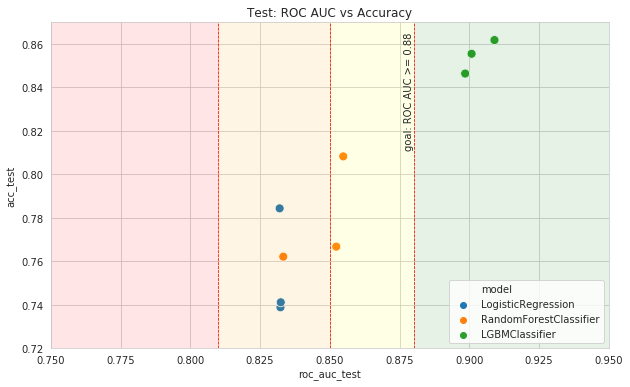

In [89]:
plt.figure(figsize=(10,6))

sns.scatterplot(results['roc_auc_test'], 
                results['acc_test'], 
                hue=results['model'],
                s=80
               )
plt.xlim((0.75, 0.95))
plt.ylim((0.72, 0.87))

plt.axvline(0.81, linestyle='--', c='r', linewidth=0.75)
plt.axvline(0.85, linestyle='--', c='r', linewidth=0.75)
plt.axvline(0.88, linestyle='--', c='r', linewidth=0.75)
plt.text(0.8765, 0.812, 'goal: ROC AUC >= 0.88', rotation='vertical')

plt.axvspan(0.75, 0.81, alpha=0.1, color='red')
plt.axvspan(0.81, 0.85, alpha=0.1, color='orange')
plt.axvspan(0.85, 0.88, alpha=0.1, color='yellow')
plt.axvspan(0.88, 0.95, alpha=0.1, color='green')

plt.legend(loc=4)
plt.title('Test: ROC AUC vs Accuracy')
plt.show()

- Взглянем теперь на самые значимые для дефолтных (лучше всех сработавших) моделей градиентного бустинга и случайного леса признаки

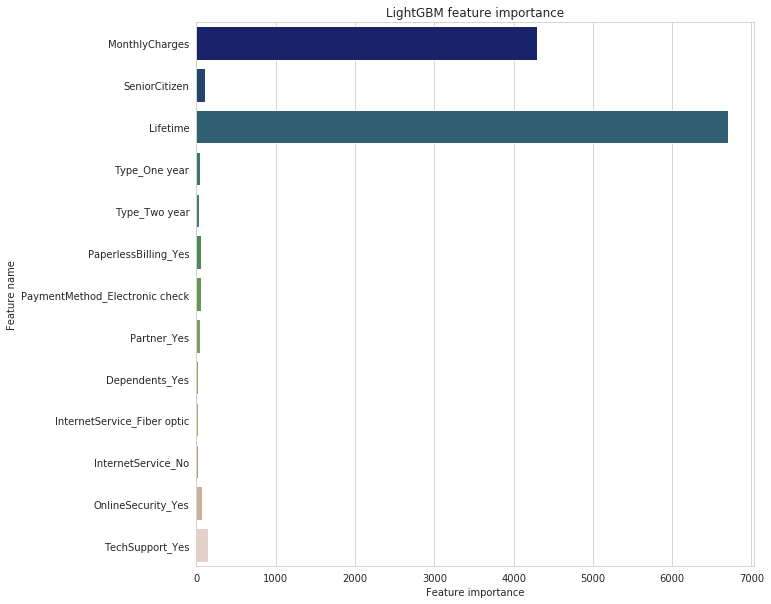

In [90]:
feat_importances_gb = pd.Series(nw_gb.named_steps['lgbmclassifier'].feature_importances_, index=X.columns)

plt.figure(figsize=(10, 10))
sns.barplot(feat_importances_gb, feat_importances_gb.index, palette='gist_earth')
plt.xlabel('Feature importance')
plt.ylabel('Feature name')
plt.title('LightGBM feature importance')
plt.show()

- Видно, что градиентный бустинг в основном опирался на количественные переменные TotalCharges, MonthlyCharges и Lifetime, которая является самой значимой для этой модели

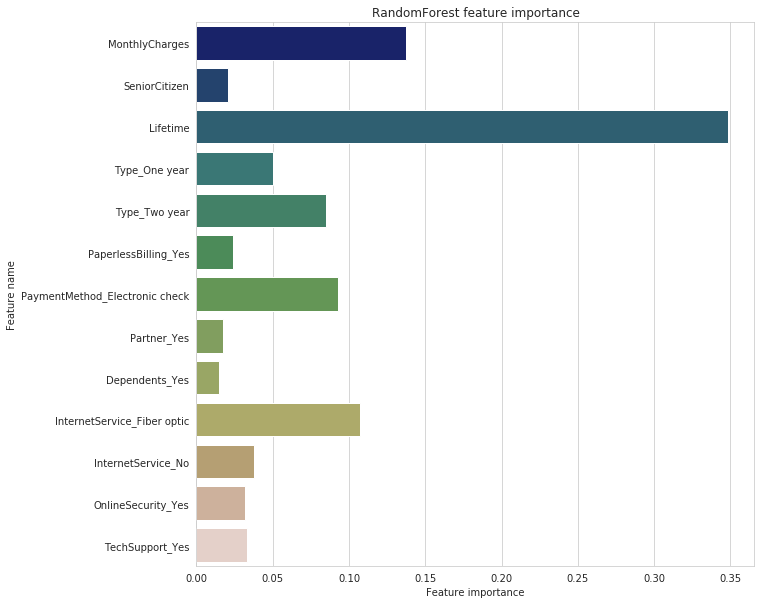

In [91]:
feat_importances_rf = pd.Series(nw_rf.feature_importances_, index=X.columns)

plt.figure(figsize=(10, 10))
sns.barplot(feat_importances_rf, feat_importances_rf.index, palette='gist_earth')
plt.xlabel('Feature importance')
plt.ylabel('Feature name')
plt.title('RandomForest feature importance')
plt.show()

- Для случайного леса также самым значимым признаком является Lifetime, далее другие количественные признаки, связанные со списаниями средств. Но здесь помимо количественных признаков также весомый вклад вносят и ряд категориальных: на два года контракт или нет, электронный чек или нет и оптоволокно используется для интернета или нет

## Выводы

- Все пункты определенного в начале плана выполнены
- Среди сложностей стоит выделить генерацию новых признаков: как правило, в этом плане лучше работать с количественными признаками, которых в данных было мало. Кроме того, можно выделить сложность в виде наличия нескольких лишних категориальных признаков
- Среди ключевых шагов можно перечислить те, которые связаны непосредственно с вышеописанными сложностями: генерация новых признаков и удаление лишних категориальных. Также для некоторых моделей помог учет дисбаланса классов целевого признака для улучшения значений метрик

- Выделются две возможные основные причины ухода клиентов:
    1. Высокие стоимости услуг. Возможно большая часть клиентов уходили сразу же после подключения из-за высокой стоимости услуг, вероятно не до конца изучив условия выбранных тарифов, либо же клиенты со временем понимали, что их использование тарифа им невыгодно и дорого
    2. Недостаточно внимательное или плохо организованное обращение и ведение новых подключившихся клиентом. Большая часть новых клиентов сразу же уходили из-за плохого сервиса и некачественного оказания услуг
- Судя по результатам моделирования, больше всего на уход клиента влияют количественные переменные, связанные с месячными затратами и общими затратами в течении времени пользования услугами
- Из категориальных переменных на факт ухода влиют наличие оптоволоконного интернета, срок контракта, наличие различных сервисов, таких как обслуживание по интернету, онлайн безопасности и технической поддержке. Кроме того, интересно, что также влияет наличие электронных чеков
- Среди моделей лучше всего справились модели градиентного бустинга, лучшая из них - дефолтная - достигла значения метрики **ROC AUC 0.91**, при этом значение **Accuracy** достигает **0.86**, что означает, что в 86% случаев модель точно определяет клиента, который уйдет